In [483]:
# imports
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (16, 8)

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std

from pscore_match.pscore import PropensityScore
from pscore_match.match import Match, whichMatched,t_test,rank_test
from scipy.stats import gaussian_kde

# this allows plots to appear directly in the notebook
%matplotlib inline

limit = 100000000

In [484]:
# read in data
sold = pd.read_csv('../CSV_backups/ALL-sales.csv',nrows=limit, index_col=['property_id','transaction_id']).drop_duplicates()

/home/ilya/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning:

Columns (12,13,14,16) have mixed types. Specify dtype option on import or set low_memory=False.



In [485]:
# only show properties that were actually sold (and a check to exclude those with wrong close dates e.g. >10000 days)
df = sold[(sold.date_closed != 0) & (sold.date_closed < 10000 )] \
        [["date_closed","price","sqft","bedrooms", "bathrooms","dist_to_lightrail_station"]]
df.rename(columns = {'date_closed':'date'}, inplace = True)

# convert days since Y2K to a nice looking date
df['date'] = df['date'].apply(lambda x: dt.date(2000, 1, 1) + dt.timedelta(days=x)) \
                       .astype("datetime64[ns]")

df = df[df.date >= dt.date(2008,12,27)]
df["year"] = df.date.dt.year
df["month"] = df.date.dt.month

df['near_rail5'] = (df['dist_to_lightrail_station'] < 5)
df['ppsf'] = (df.price / df.sqft)

df.head(6)

,,date,price,sqft,bedrooms,bathrooms,dist_to_lightrail_station,year,month,near_rail5,ppsf
property_id,transaction_id,,,,,,,,,,
346200,23951313,2014-10-24,400000,2388,4,3,0.700000,2014,10,True,167.504188
9020277,23951289,2015-05-19,320000,2120,4,2,5.905930,2015,5,False,150.943396
336902,23951266,2018-03-13,285000,1723,3,2,0.844038,2018,3,True,165.409170
990354,23951257,2017-12-05,367000,2286,3,2,13.006200,2017,12,False,160.542432
9000471,23951250,2018-01-13,369000,1502,3,2,17.024700,2018,1,False,245.672437
9035951,23951029,2017-11-30,182500,1721,3,2,1.402180,2017,11,True,106.042998


In [486]:
df.describe()

,price,sqft,bedrooms,bathrooms,dist_to_lightrail_station,year,month,ppsf
count,181405.000000,181405.000000,181405.000000,181405.000000,181405.000000,181405.000000,181405.000000,181405.000000
mean,175616.201108,1654.399239,3.022453,1.952085,7.562902,2013.327698,6.468636,107.941167
std,86085.454605,461.073003,1.042174,0.585558,4.716730,2.734120,3.366809,48.918728
min,50000.000000,500.000000,0.000000,0.000000,0.000000,2008.000000,1.000000,14.184997
25%,106614.000000,1338.000000,3.000000,2.000000,3.801110,2011.000000,4.000000,70.267686
50%,160000.000000,1596.000000,3.000000,2.000000,6.906290,2013.000000,6.000000,102.564103
75%,230000.000000,1900.000000,4.000000,2.000000,10.593300,2016.000000,9.000000,137.636081
max,400000.000000,4000.000000,6.000000,6.000000,23.368200,2018.000000,12.000000,641.666667


We create a `pscore` for each home that categorizes how similar it is to other homes in the dataset. 

We divide the sample into `treated` sample - homes near transit stations - and `control` - meaning homes farther away. Because we suspect distributions of the two samples are not identical we normalize the control sample to have the same distribution of home sizes as the tested sample.

Second, we control for the trends in house prices over the time period by splitting up the dataset into years. We calculate the effect of rail proximity for each year's sample independently.

We match each treated home with three control homes, with replacement. 

In [487]:
# List of variables to use for the pscore
cov_list = ['month','sqft','bedrooms','bathrooms']

k = np.zeros([10,3])
result = pd.DataFrame(k, index=np.arange(2009,2019),columns=['control','near_rail','premium'])


for year in range(2009,2019):
    d = df[df.year==year]
        
    treatment = np.array(d.near_rail5)
    covariates = d[cov_list].reset_index()
    covariates.drop(['property_id','transaction_id'],axis=1,inplace=True)
    
    pscore = PropensityScore(treatment, covariates).compute()

    pairs = Match(treatment, pscore)
    pairs.create(method='many-to-one', many_method='knn', k=3, replace=True)
    data_matched = whichMatched(pairs, pd.DataFrame({'pscore': pscore, 'treatment' :treatment, 'ppsf':d.ppsf}))
    
    treated_ppsf = d.ppsf[treatment == 1].mean()
    control_ppsf = d.ppsf[treatment==0].mean()
    matched_control_ppsf = data_matched.ppsf[data_matched.treatment==0].mean()
    ATT = treated_ppsf - control_ppsf
    matched_ATT = treated_ppsf - matched_control_ppsf
    result.loc[year] = [matched_control_ppsf,treated_ppsf,matched_ATT]
    

We look at the distribution of `pscore` in the control group before and after we matched samples. This is done only for 2018 (last year of the loop above). As we can see, before matching there were some significant differences in distributions. But after we match homes, distributions of `pscores` look identical allowing us to make inferences from simple means.

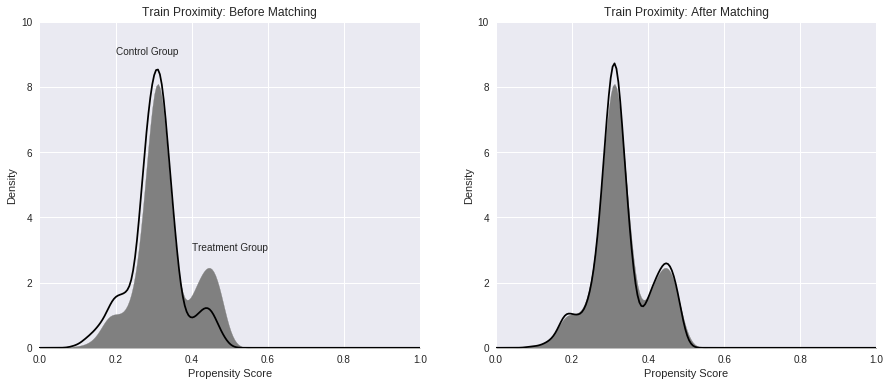

In [495]:
plt.figure(1,figsize=(15,6))
plt.subplot(121)
density0 = gaussian_kde(pscore[treatment==0])
density1 = gaussian_kde(pscore[treatment==1])
xs = np.linspace(0,1,200)
plt.plot(xs,density0(xs),color='black')
plt.fill_between(xs,density1(xs),color='gray')
plt.text(0.2, 9, 'Control Group')
plt.text(0.4, 3, 'Treatment Group')
plt.title('Train Proximity: Before Matching')
plt.axis([0,1,0,10])
plt.xlabel('Propensity Score')
plt.ylabel('Density')

plt.subplot(122)
density0_post = gaussian_kde(data_matched.pscore[data_matched.treatment==0])
density1_post = gaussian_kde(data_matched.pscore[data_matched.treatment==1])
xs = np.linspace(0,1,200)
plt.plot(xs,density0_post(xs),color='black')
plt.fill_between(xs,density1_post(xs),color='gray')
plt.title('Train Proximity: After Matching')
plt.axis([0,1,0,10])
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.show()

Finally, we calculate the actual premium per square foot for homes located near public transit stops. Compared to the same analysis done using OLS, premium for light rail is consistently higher by $2-3/sq ft across the time period examined. The negative effects in 2009-2014 have become neutral (except for 2010 when it was negative and 2014, when negative effect became a strong positive). Notably the positive effect appears to be growing even in 2018, ten years after the light rail began operating. 

An interesting takeaway from this study is the material positive effect on Maricopa County tax assessments. For a 1,700 sq ft house, the increase in property values associated with light rail operation represents an increase in annual property tax of $222/year. Municipalities should consider this increase in tax revenue as a potential funding source for light rail expansion or construction.

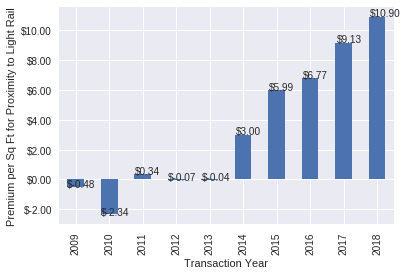

In [489]:
ax = result.premium.plot(kind="bar")
for p in ax.patches:
    b = p.get_bbox()
    val = "${:3.2f}".format(b.y1 + b.y0)
    ax.annotate(val, (p.get_x() * 1.005, p.get_height() * 1.005))
    
# manipulate
vals = ax.get_yticks()
ax.set_yticklabels(['${:3.2f}'.format(x) for x in vals])
ax.set_ylabel("Premium per Sq Ft for Proximity to Light Rail")
ax.set_xlabel("Transaction Year")
ax

Finally we show the average `ppsf` values for each year for homes far and near light rail, and the associate premiums. Despite the different conclusions above, we find the annual appreciation rates for homes near and farther from light rail to be exactly the same as in the OLS method. Homes near light rail are expected to appreciate 1% faster than homes farther away.

         control   near_rail    premium
2009   88.306000   87.826520  -0.479480
2010   88.284999   85.946288  -2.338711
2011   81.126649   81.467956   0.341308
2012   86.772206   86.707145  -0.065061
2013  101.783257  101.748036  -0.035222
2014  109.320764  112.323125   3.002361
2015  117.738727  123.729424   5.990697
2016  127.414927  134.187986   6.773059
2017  140.821460  149.952628   9.131168
2018  143.439614  154.336424  10.896811
Price per foot CAGR of homes far from light rail stations 5.54% 
Price per foot CAGR of homes near to light rail stations 6.46% 


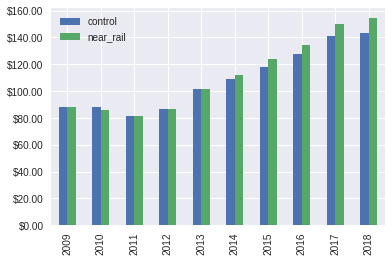

In [498]:
print(result)
def CAGR(first, last, periods):
    return (last/first)**(1/periods)-1
print('Price per foot CAGR of homes far from light rail stations {:.2%} '.format(CAGR(result['control'][2009], result['control'][2018], 2018-2009)))
print('Price per foot CAGR of homes near to light rail stations {:.2%} '.format(CAGR(result['near_rail'][2009], result['near_rail'][2018], 2018-2009)))
ax =result[['control','near_rail']].plot(kind="bar")
vals = ax.get_yticks()
ax.set_yticklabels(['${:3.2f}'.format(x) for x in vals])
ax